# Housing Maintenance Violation Code Analysis
 By Amy Chen, Claudia Ye, and Jeffrey Liu

__This is an analysis of the data reported by the Department of Housing Preservation and Development (HPD). HPD issues violations to rental dwelling units that have violated either Housing Maintenance Code or the New York State Multiple Dwelling Law. __



Tenants can directly consult their landlord or file an official complaint if an issue is discovered in their apartment. These complaints are directed to the HPD, who in turn contacts the building's managing agent informing them of the complaint. The HPD will then follow up the complaint to ensure that the issue has been resolved and thus would close complaint. If the issue continues to be unresolved, the HPD would send a Code Inspector to check for housing or safety violations. The complaints are categorized into either class A, B, C, and I, with class A being least sever and class C being most severe, such as problems with heating and hot water (Class I cases are unique and indicate a serious hazard). The violations persist on file and the complaint cases remain open until the HPD can confirm that the owner has sufficiently corrected the condition.

With the rapidly increasing population of New York City, we wanted to analyze whether landlords are starting to break housing and preservation laws more frequently in these recent years. With the dataset from NYC Housing Preservation and Development, we had access to housing data for the five boroughs in NYC, so we were able to narrow down which boroughs resulted in the largest number of violations. With that, we also wanted to see whether there is a correlation between complaints and violations (e.g. how often complaints turned into violations upon inspection). Ultimately, we wanted to have a better understanding of how HPD goes about maintaining housing in NYC and whether NYC’s rising population density in recent years has resulted in an influx of violations. 

# Set Up

<B> Downloading Packages

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

# Retrieving Data

<B> Here is a look at the housing violation data. As of when the file was downloaded, there are  5,073,046 housing violations and the dataset is continuously getting updated. We will take a random sample of that dataset and work with that data. We are using a sample because of the lack of processing power required to process the entire dataset. The use of the sample should suffice because the data will still exhibit the concentrations and ratios we seek to analyze.

In [38]:
housing = pd.read_csv('https://data.cityofnewyork.us/api/views/wvxf-dwi5/rows.csv?accessType=DOWNLOAD')

/Users/claudia/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
housing = housing.sample(frac=0.1)

<B> Our sample is 10% of the original dataset and consists of 507,3046 violations

In [55]:
len(housing)

507305

<B> Let's look at what kind of data we're working with in order to decide what to analyze

In [56]:
housing.columns

Index(['ViolationID', 'BuildingID', 'RegistrationID', 'BoroID', 'Borough',
       'HouseNumber', 'LowHouseNumber', 'HighHouseNumber', 'StreetName',
       'StreetCode', 'Postcode', 'Apartment', 'Story', 'Block', 'Lot', 'Class',
       'InspectionDate', 'ApprovedDate', 'OriginalCertifyByDate',
       'OriginalCorrectByDate', 'NewCertifyByDate', 'NewCorrectByDate',
       'CertifiedDate', 'OrderNumber', 'NOVID', 'NOVDescription',
       'NOVIssuedDate', 'CurrentStatusID', 'CurrentStatus',
       'CurrentStatusDate', 'NovType', 'ViolationStatus', 'Latitude',
       'Longitude', 'CommunityBoard', 'CouncilDistrict', 'CensusTract', 'BIN',
       'BBL', 'NTA'],
      dtype='object')

In [57]:
housing.head(10)

ViolationID  BuildingID  RegistrationID  BoroID   Borough  \
1814878      7399679      120448          214706       2     BRONX   
1940989      8968521       65958          207623       2     BRONX   
3646577      9628705      556316          402461       4    QUEENS   
4331893     12209898      467138          400147       4    QUEENS   
4064247      9849099      120620          213360       2     BRONX   
645981      10879241      351169          336169       3  BROOKLYN   
3723697      9731313      120577          215758       2     BRONX   
379021      10582724      370985          342210       3  BROOKLYN   
916630      11184520      239013          300549       3  BROOKLYN   
3599187      9566018      306458               0       3  BROOKLYN   

        HouseNumber LowHouseNumber HighHouseNumber       StreetName  \
1814878        1237           1237            1237   WEBSTER AVENUE   
1940989         234            234             234  EAST 178 STREET   
3646577       89-04          89-02           89-04       146 STREET   
4331893      110-45         110-45          110-45          71 ROAD   
4064247        2366           2366            2366   WEBSTER AVENUE   
645981          161            161             161      PARK AVENUE   
3723697        2097           2097            2097   WEBSTER AVENUE   
379021          231            231             231     SMITH STREET   
916630          623            623             623    EAST 5 STREET   
3599187          35             35              35    HAMPTON PLACE   

         StreetCode                        ...                         \
1814878       73720                        ...                          
1940989       27000                        ...                          
3646577       23040                        ...                          
4331893       15040                        ...                          
4064247       73720                        ...                          
645981        69230                        ...                          
3723697       73720                        ...                          
379021        77730                        ...                          
916630        35030                        ...                          
3599187       46980                        ...                          

          NovType ViolationStatus   Latitude  Longitude  CommunityBoard  \
1814878  Original           Close  40.832749 -73.909370             4.0   
1940989  Original           Close  40.850316 -73.904097             5.0   
3646577  Original            Open  40.703259 -73.809559            12.0   
4331893  Original           Close  40.721776 -73.840806             6.0   
4064247  Original           Close  40.857916 -73.894496             6.0   
645981   Original            Open  40.696230 -73.972971             2.0   
3723697  Original           Close  40.852463 -73.898018             5.0   
379021        NaN            Open  40.683912 -73.992360             6.0   
916630   Original           Close  40.637053 -73.974299            12.0   
3599187  Original           Close  40.671697 -73.940865             8.0   

        CouncilDistrict CensusTract        BIN           BBL  \
1814878            16.0     17701.0  2002115.0  2.024270e+09   
1940989            15.0     23502.0  2092051.0  2.028100e+09   
3646577            24.0       240.0  4206712.0  4.096750e+09   
4331893            29.0     75702.0  4052571.0  4.022340e+09   
4064247            15.0     38302.0  2011192.0  2.030310e+09   
645981             35.0       211.0  3058005.0  3.020310e+09   
3723697            15.0       379.0  2013311.0  2.031430e+09   
379021             33.0        69.0  3006544.0  3.004090e+09   
916630             39.0       490.0  3126793.0  3.053890e+09   
3599187            35.0       339.0  3032095.0  3.012510e+09   

                                                      NTA  
1814878                  East Concourse-Concourse Village  
1

__There are many dates that are being used in this dataset. We will convert the inspection date and approval date into datetime since they are currently strings. By converting them, we will create a new column called "Time Until Approval" to see how long it takes the Department of Building to approve. Within this dataset, about 39.1% of the violations are still open. __

To find the percentage of violations that are still open, we create a variable grouped by the column "ViolationStatus", and then count the amount of open and closed violations. Then we divide the number of open violations by the total.

In [88]:
open_close = housing.groupby('ViolationStatus').count()
open_close['ViolationID'].iloc[1] / (open_close['ViolationID'].iloc[1] + open_close['ViolationID'].iloc[0])

0.3909107047754305

<B> We will look at data starting from the 1980s since there aren't many data points in the file for anything before then. Within the last 30-40 years, there seems to be an exponential growth in housing violations. The graph that is displayed shows the change over time in years.

Here we are converting inspection and approval date into datetime.

In [59]:
housing['InspectionDate'] = pd.to_datetime(housing['InspectionDate'], format="%m/%d/%Y", errors = 'coerce')
housing['ApprovedDate'] = pd.to_datetime(housing['ApprovedDate'], format="%m/%d/%Y", errors = 'coerce')

In [60]:
housing['Time_Until_Approval'] = (abs(housing['ApprovedDate'] - housing['InspectionDate']))
housing['Time_Until_Approval'] = (housing['Time_Until_Approval'] / np.timedelta64(1, 'D')).fillna(0).astype(int)

Now we specify that we only want to plot data after 1980.

In [61]:
housing_past_1980 = housing[(housing.InspectionDate > '1980-01-01')]

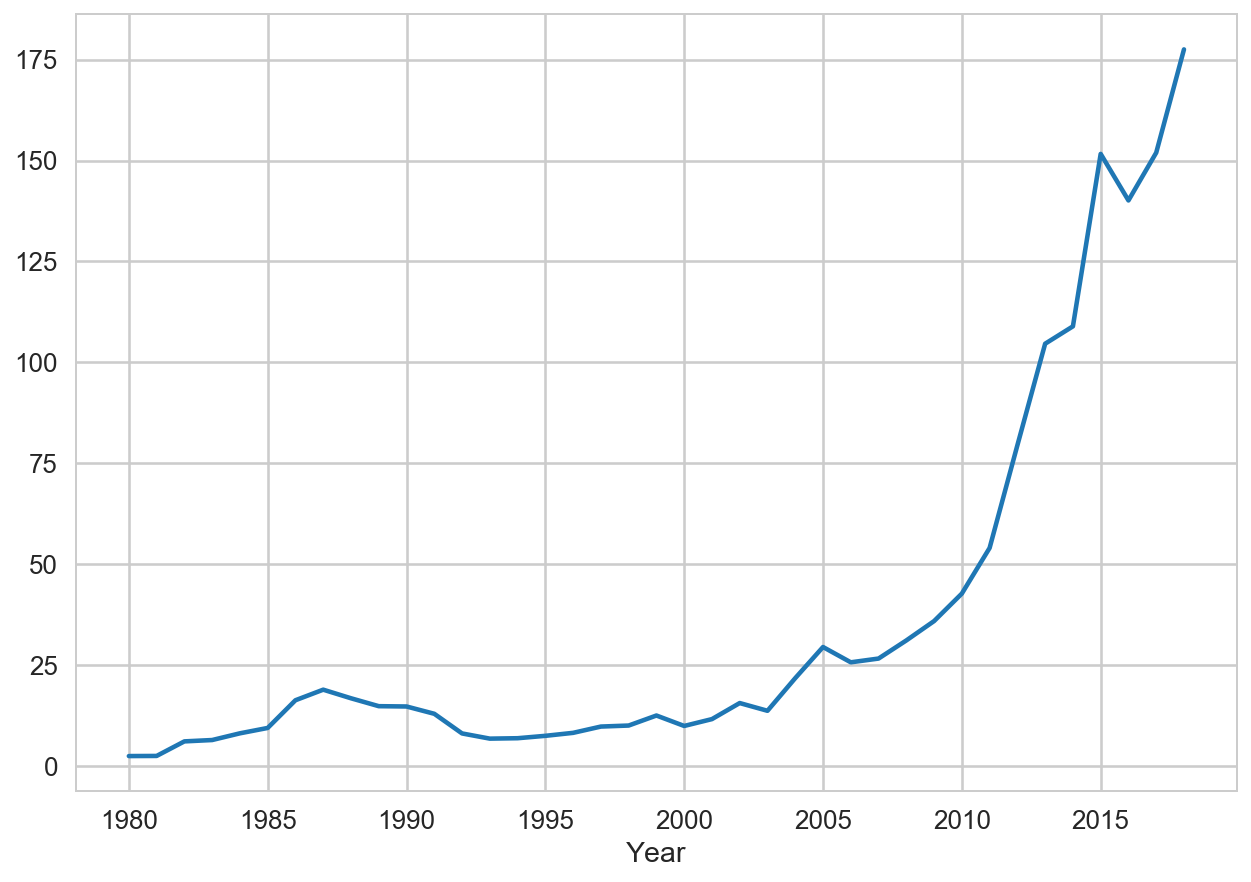

In [62]:
matplotlib.pyplot.xlabel("Year")
housing_past_1980.InspectionDate.value_counts().sort_index().resample('AS').mean().plot()

__We will now look at how many unique violations there are. The order number references to the abstract description of the violation condition which cites a specific section of the law which is in violation. From the code below, we find that there are <b>350</b> unique violation. That's 4955054:350 individual violations to violation code. 508 is the most popular order number.__

1. 508: REPAIR THE BROKEN OR DEFECTIVE PLASTERED SURFACES AND PAINT IN A UNIFORM COLOR
2. 501: REPAIR THE BROKEN OR DEFECTIVE
3. 502: PROPERLY REPAIR WITH SIMILAR MATERIAL THE BROKEN OR DEFECTIVE
4. 780: OWNER FAILED TO FILE A VALID REGISTRATION STATEMENT WITH THE DEPARTMENT AS REQUIRED BY ADM CODE §27-2097 AND IS THEREFORE SUBJECT TO CIVIL PENALTIES, PROHIBITED FROM CERTIFYING VIOLATIONS, AND DENIED THE RIGHT TO RECOVER POSSESSION OF PREMISES FOR NONPAYMENT OF RENT UNTIL A VALID REGISTRATION STATEMENT IS FILED.
5. 556: PAINT WITH LIGHT COLORED PAINT TO THE SATISFACTION OF THIS DEPARTMENT
6. 702: REPAIR OR REPLACE THE SMOKE DETECTOR
7. 510: 309 M/D LAW ABATE THE NUISANCE CONSISTING OF
8. 505: REPLACE WITH NEW THE BROKEN OR DEFECTIVE
9. 583: PROPERLY REPAIR THE SOURCE AND ABATE THE EVIDENCE OF A WATER LEAK
10. 550: TRACE AND REPAIR THE SOURCE AND ABATE THE NUISANCE CONSISTING OF MOLD ...

To find the number of unique orders, we converted the order in the column "OrderNumber" into a string and then see how many are unique.

In [63]:
housing['OrderNumber'] = [str(order) for order in housing['OrderNumber']]
print(housing['OrderNumber'].nunique())

350


This graph displays the ten most popular violations by their order numbers.

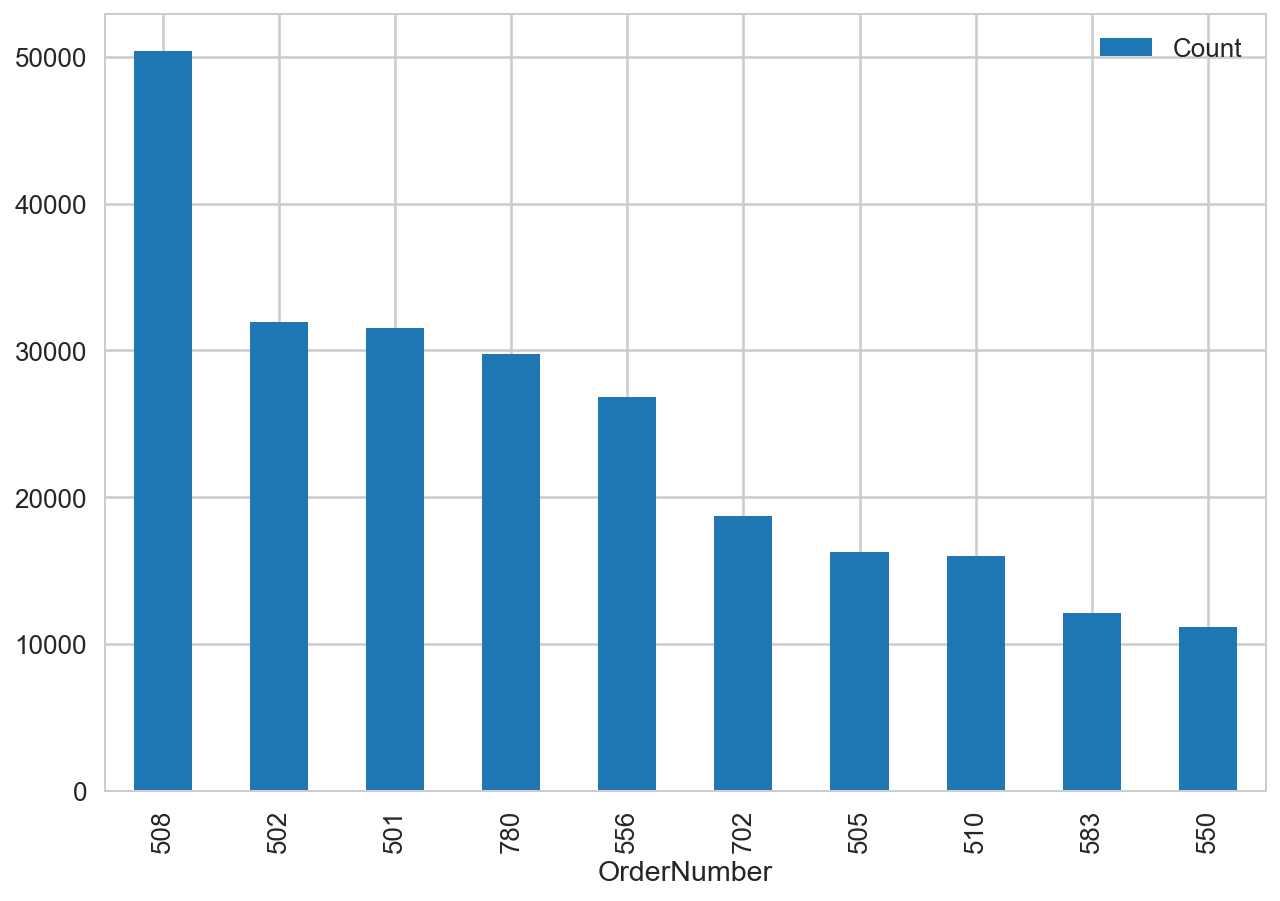

In [64]:
orderNumberViolation = housing[['ViolationID', 'OrderNumber']].groupby('OrderNumber').count().rename(columns={"ViolationID":"Count"})
orderNumberViolation.sort_values('Count', ascending=False).head(10).plot(kind='bar')

__We will now look at the number of violations in each borough. Here, Brooklyn has the most violation. The violations are also plotted on the NYC map which I got from geojson. Data without a latitude and longitude are dropped since they were causing errors. The lighter the purple, the less concentration of violation.__

In [65]:
housing = housing.dropna(subset=['Latitude', 'Longitude'])

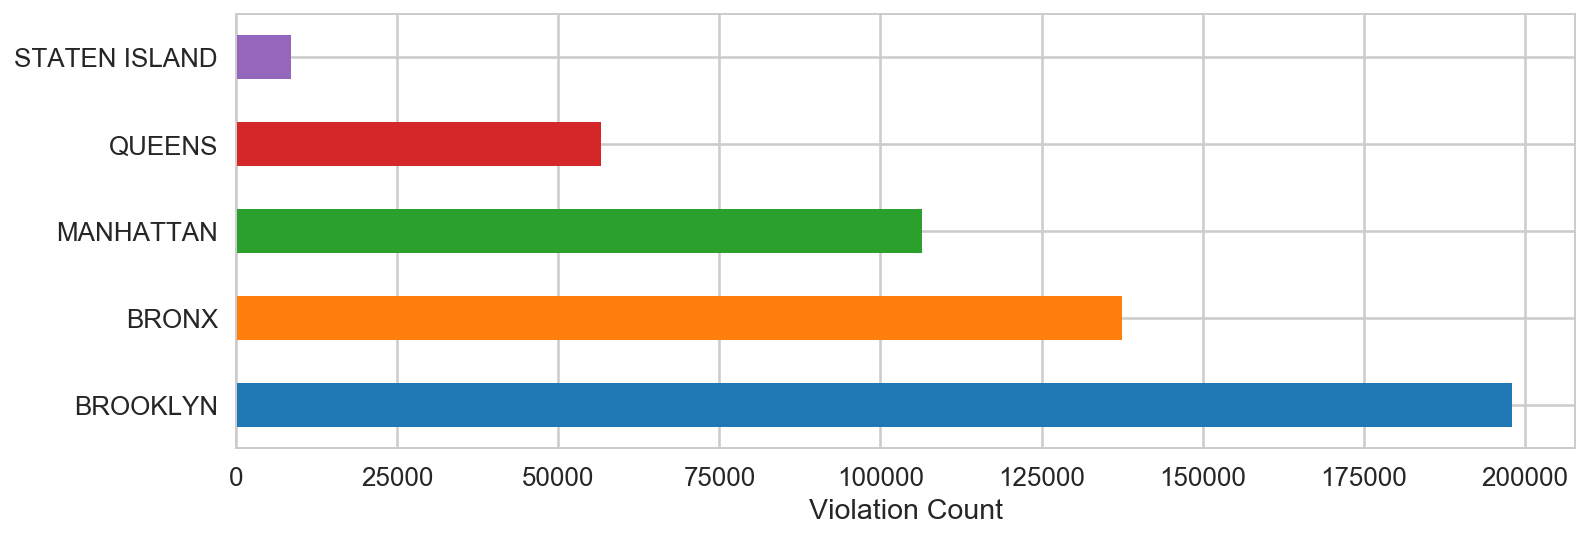

In [66]:
matplotlib.pyplot.xlabel("Violation Count")
housing.Borough.value_counts().plot(kind='barh', figsize=(12,4))

In [67]:
!curl 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON' -o nyc-neighborhoods.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4067k    0 4067k    0     0   866k      0 --:--:--  0:00:04 --:--:-- 1036k4046k    0     0   862k      0 --:--:--  0:00:04 --:--:--  861k


In [68]:
df_nyc = gpd.GeoDataFrame.from_file('nyc-neighborhoods.geojson')

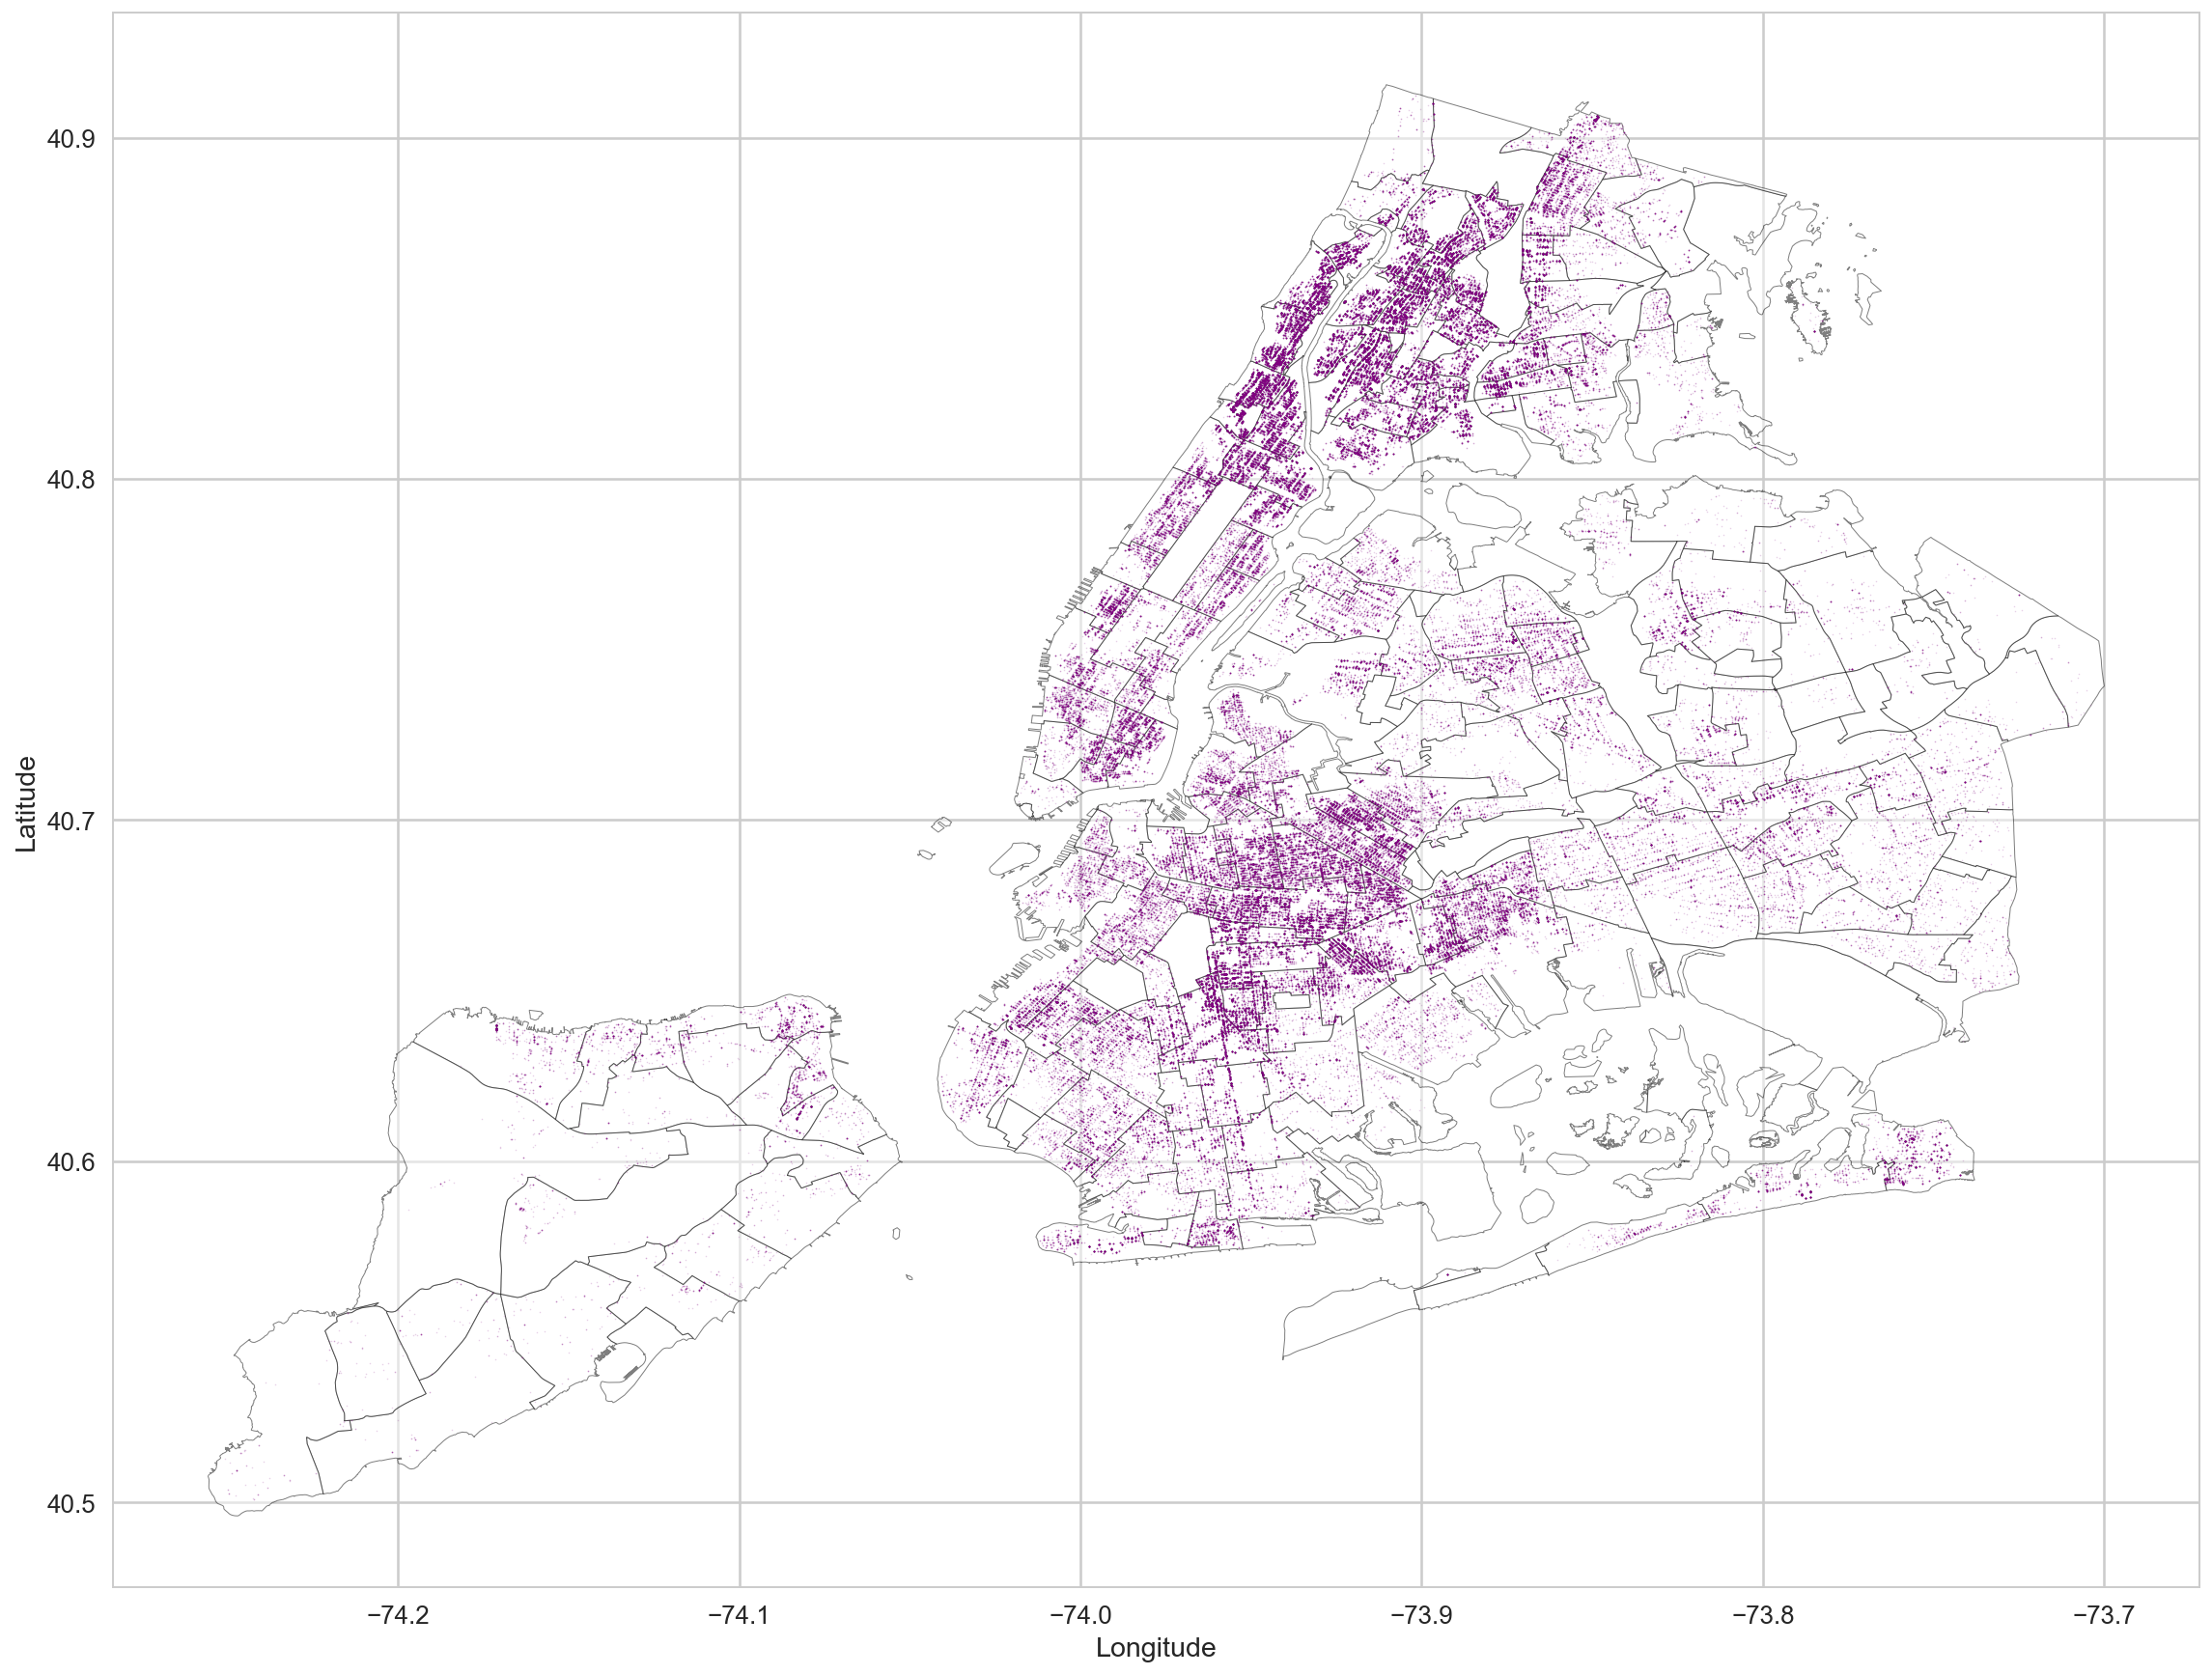

In [69]:
ny_map = df_nyc.plot(linewidth=0.5, color='White', edgecolor = 'Black', figsize = (20,15), alpha=0.5)

housing_loc = housing.sample(frac=0.7).plot.scatter(
    x="Longitude", 
    y="Latitude",
    figsize=(20,15),
    s=0.3,
    color='purple',
    alpha=0.1,
    ax=ny_map
)

__The following graph below takes 10% of the sample data and plots a KDE map from it. The map may be a bit inaccurate, but generally speaking, it should be okay because higher concentrations of violation will still be mapped out.__

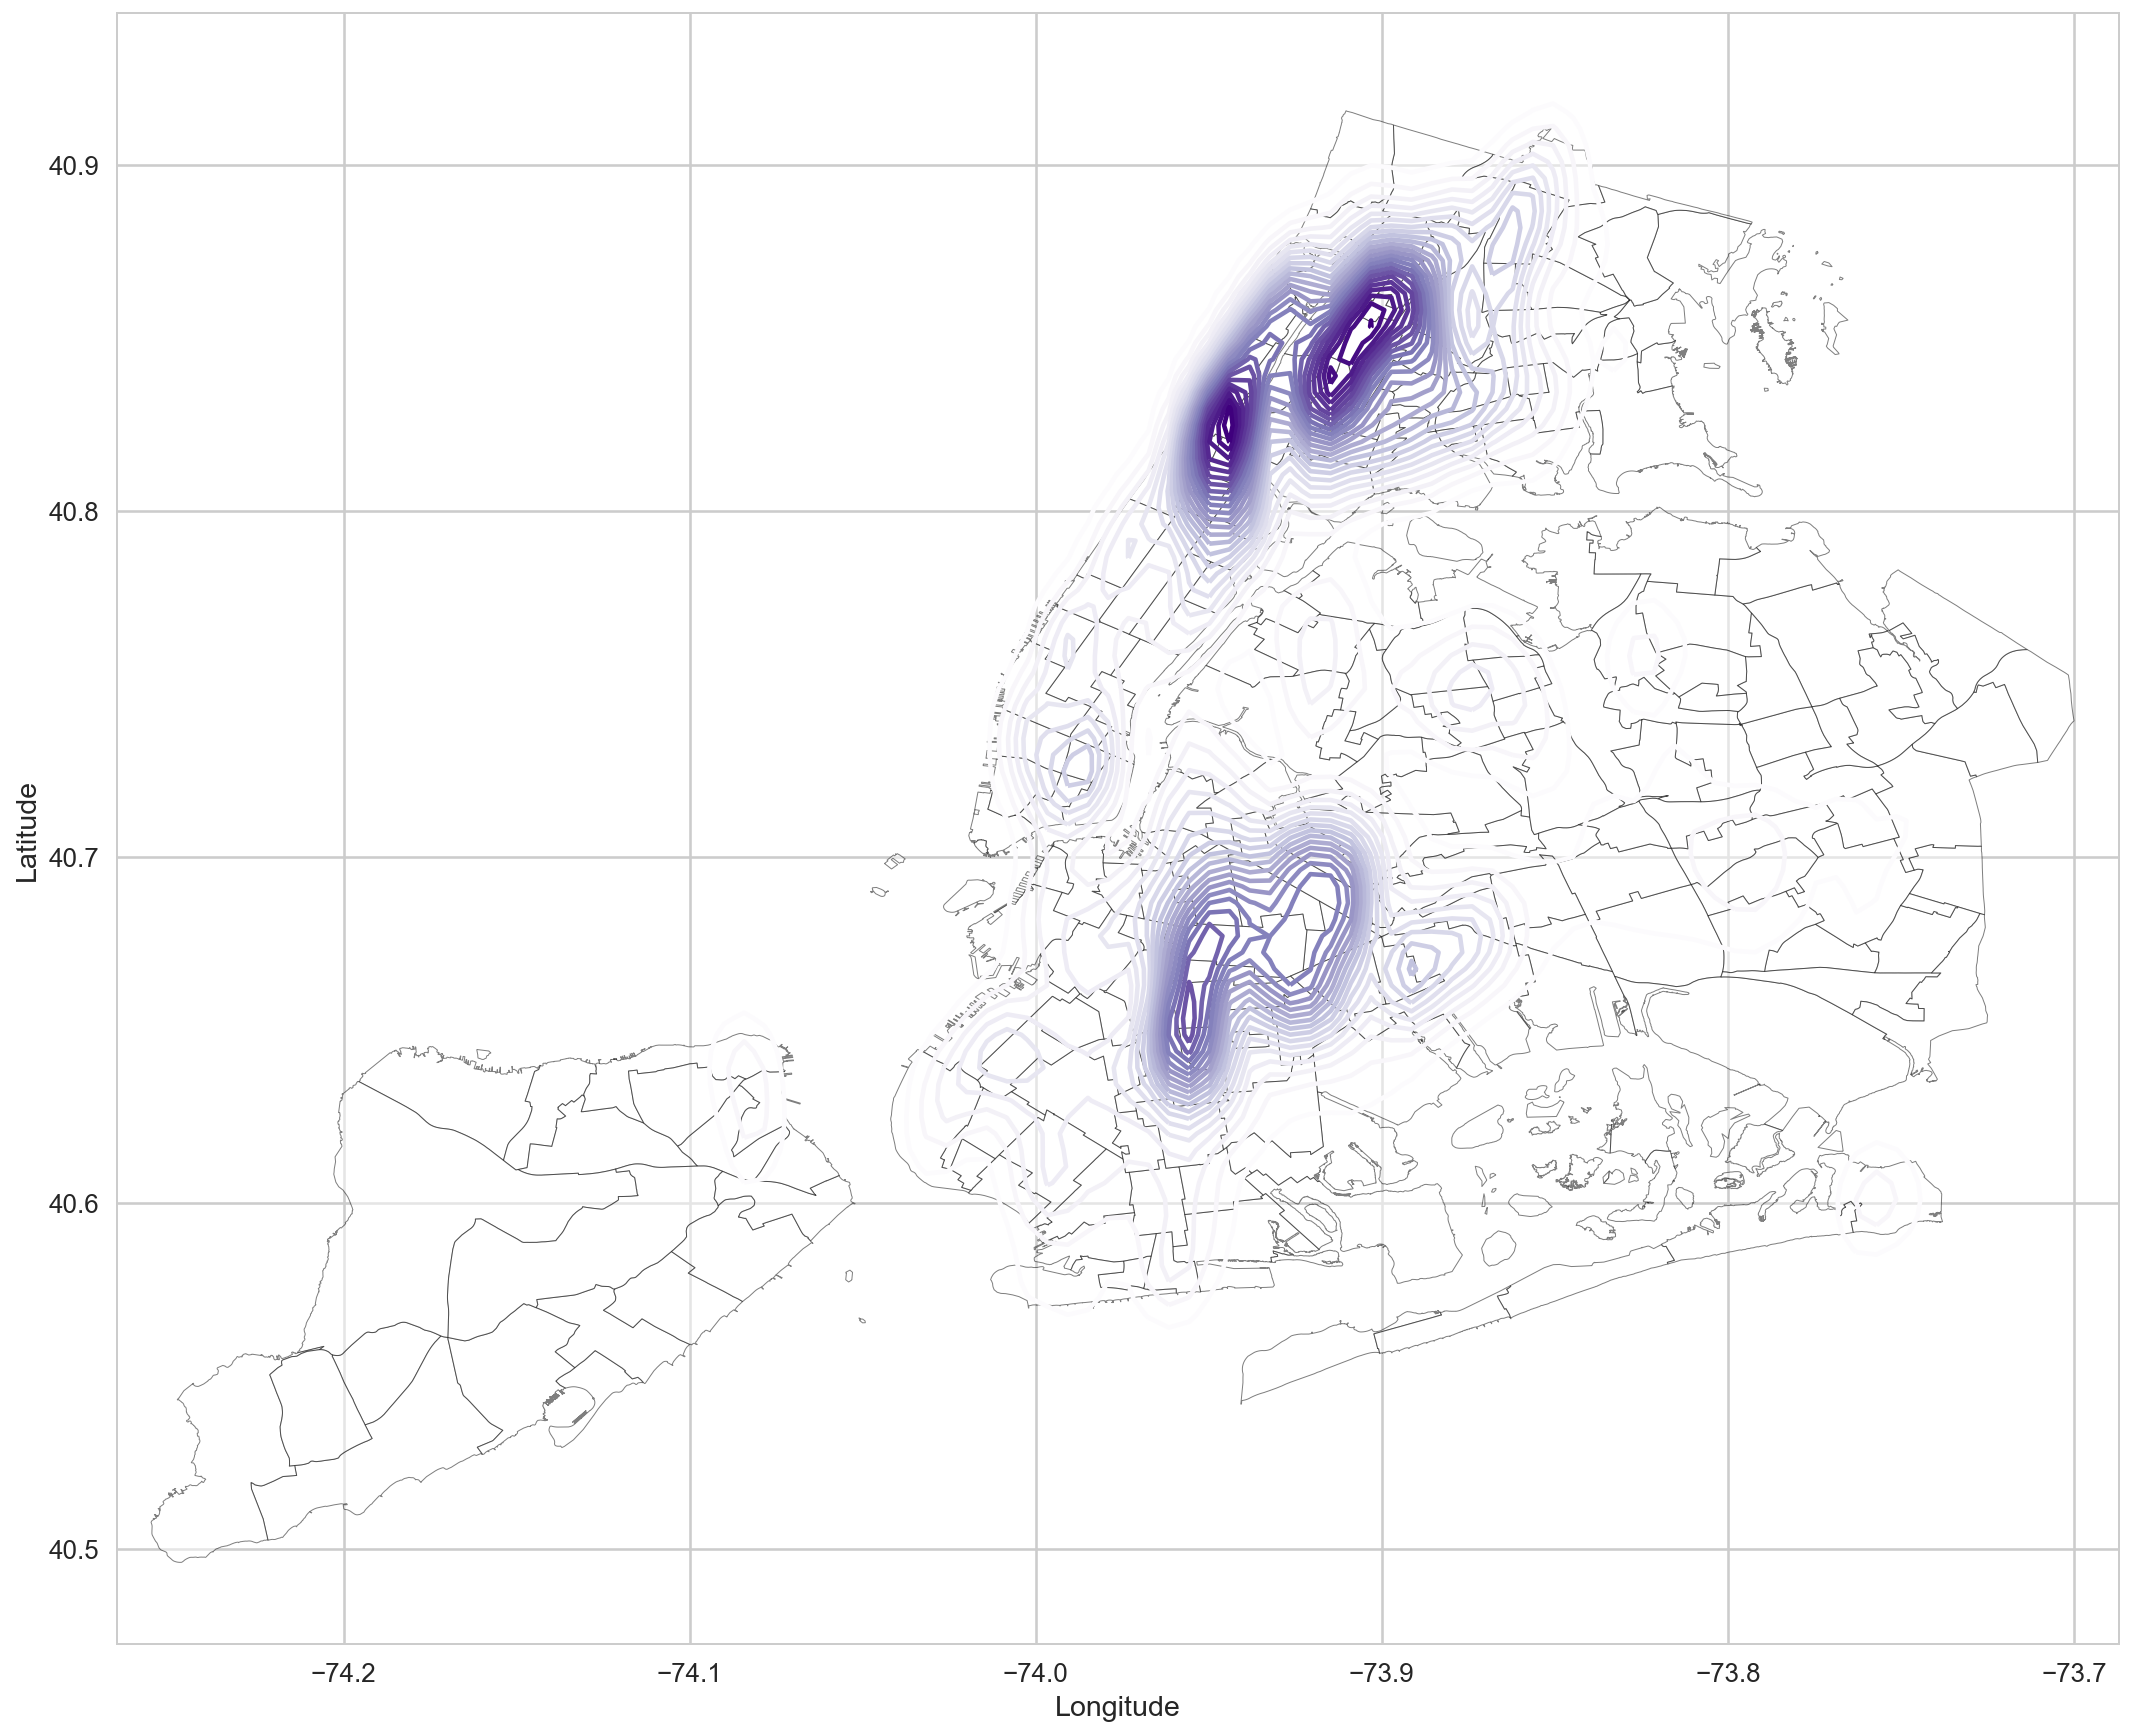

In [70]:
ny_map = df_nyc.plot(linewidth=0.5, color='White',edgecolor = 'Black', figsize = (20,15), alpha=0.5)

sample = housing.sample(frac=0.1)
sns.kdeplot(
    sample.Longitude, sample.Latitude,
    gridsize=100,
    cmap=plt.cm.Purples,
    shade_lowest=False,
    n_levels=30,
    ax=ny_map
)

<B>The following graph represents the time it takes for the department of building to approve a violation depending on the class of the violation. <B>

<I>A</I> class violation is the least severe and the <I>C</I> class is the most severe. *I* class is considered hazardous.

We will disregard Staten Island and the Bronx here because of they have less cases of buildings with housing violations.

In the graph repsented below, <I>C</I> class violations (most severe) take the most time to get approved in Queens, followed by Brooklyn, then Manhattan. The <I>A</I> class violation takes the longest to get approved in Brooklyn, then Queens, then Manhattan. 

In Manhattan, the approval rate is generally much faster than the other boroughs. Queens seems to have the slowest approval rate in all cases except class <I>B</I>, with Brooklyn being the slowest in that case.

To obtain this bar graph, we take "Time_Until_Approval" and graph it against "Class". 

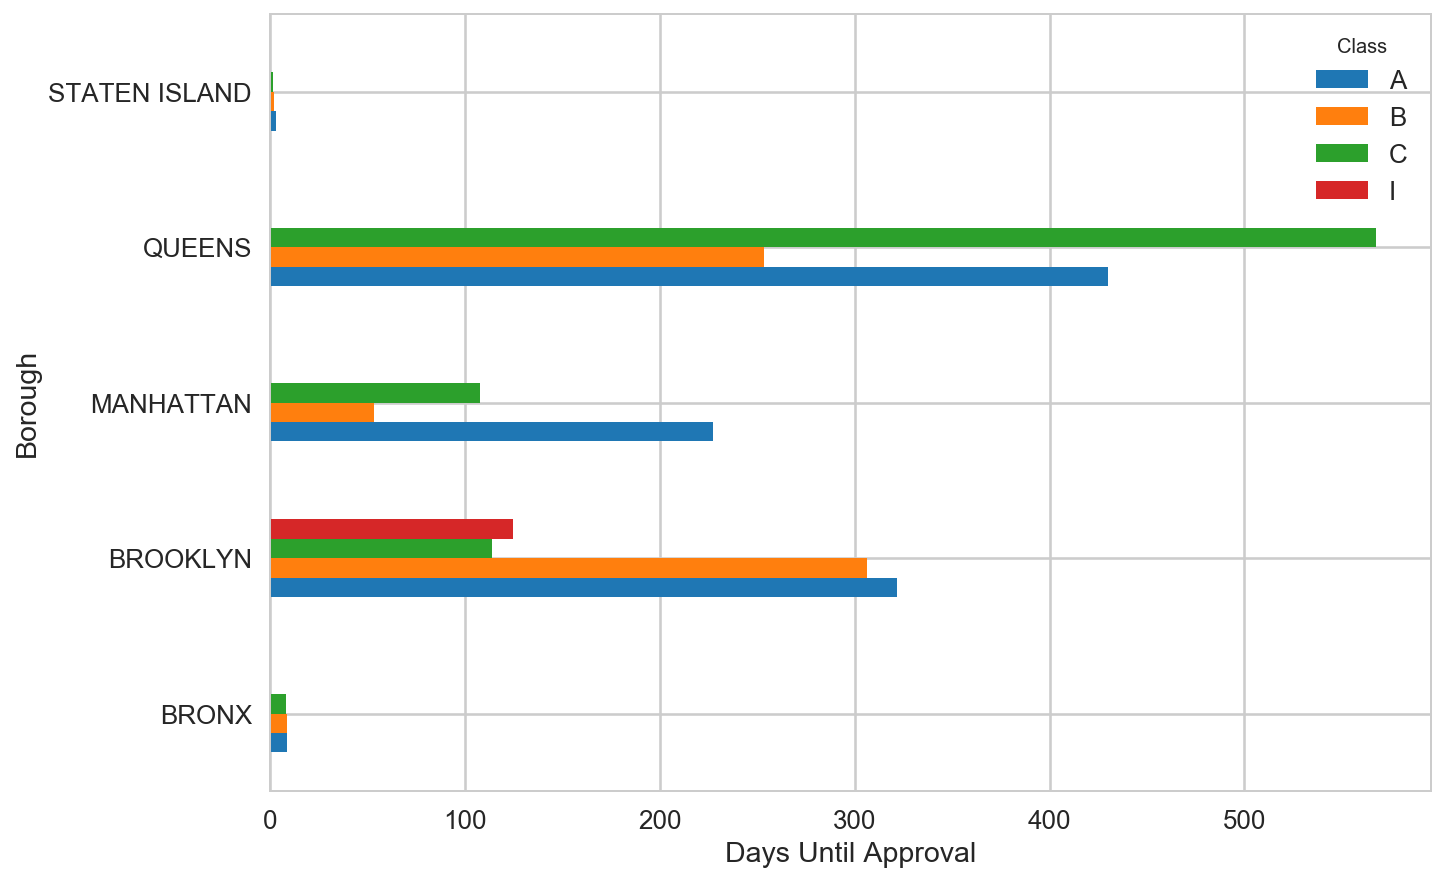

In [90]:
approval = housing[['Time_Until_Approval', 'Class']].set_index("Class")
approval_time= pd.pivot_table(
    data = housing.sample(3000),
    index='Borough',
    columns='Class',
    values='Time_Until_Approval'
).plot.barh().set_xlabel('Days Until Approval')

__There's not a lot of I class (hazardous) violations compared to the other 3 classes, so let's look into that. Clearly from the KDE map and the value_counts, Brooklyn has the greatest number of I class violations.__


To obtain this data, we first create a new dataframe which we named "classI", which contains the 'HouseNumber', 'StreetName', 'Borough', 'Latitude', and 'Longitude' columns for only the class I violations.

In [72]:
classI = housing.loc[housing['Class']=="I", ['HouseNumber', 'StreetName', 'Borough', 'Latitude', 'Longitude']]
classI.head(10)

HouseNumber        StreetName    Borough   Latitude  Longitude
379021          231      SMITH STREET   BROOKLYN  40.683912 -73.992360
1176897        1330         52 STREET   BROOKLYN  40.632856 -73.993068
4992567         126    VERMONT STREET   BROOKLYN  40.676934 -73.895186
4006248         339     ELLERY STREET   BROOKLYN  40.700324 -73.938849
4480670        4396   BEACH 44 STREET   BROOKLYN  40.574878 -74.010259
4626726        1812    PALISADE PLACE      BRONX  40.852018 -73.918340
1153541         107  MANHATTAN AVENUE  MANHATTAN  40.797577 -73.962283
383345       143-17         38 AVENUE     QUEENS  40.762306 -73.824320
4112363       69-21         78 STREET     QUEENS  40.709148 -73.874601
3987094       85-33          60 DRIVE     QUEENS  40.728980 -73.873182

Then we found which Borough had the most class I violations, which turned out to be Brooklyn.

In [73]:
classI['Borough'].value_counts()

BROOKLYN         15097
QUEENS            6875
BRONX             4549
MANHATTAN         4032
STATEN ISLAND      517
Name: Borough, dtype: int64

<B> Here is the list containing the top ten streets for class I violations.

In [74]:
classI["StreetName"].value_counts().head(10)

GREENE AVENUE       179
BEDFORD AVENUE      137
PUTNAM AVENUE       131
MADISON STREET      123
5 AVENUE            121
3 AVENUE            118
41 STREET           114
HANCOCK STREET      112
60 STREET           112
JEFFERSON AVENUE    107
Name: StreetName, dtype: int64

__This is a map of all the I class violations found in NYC__ 

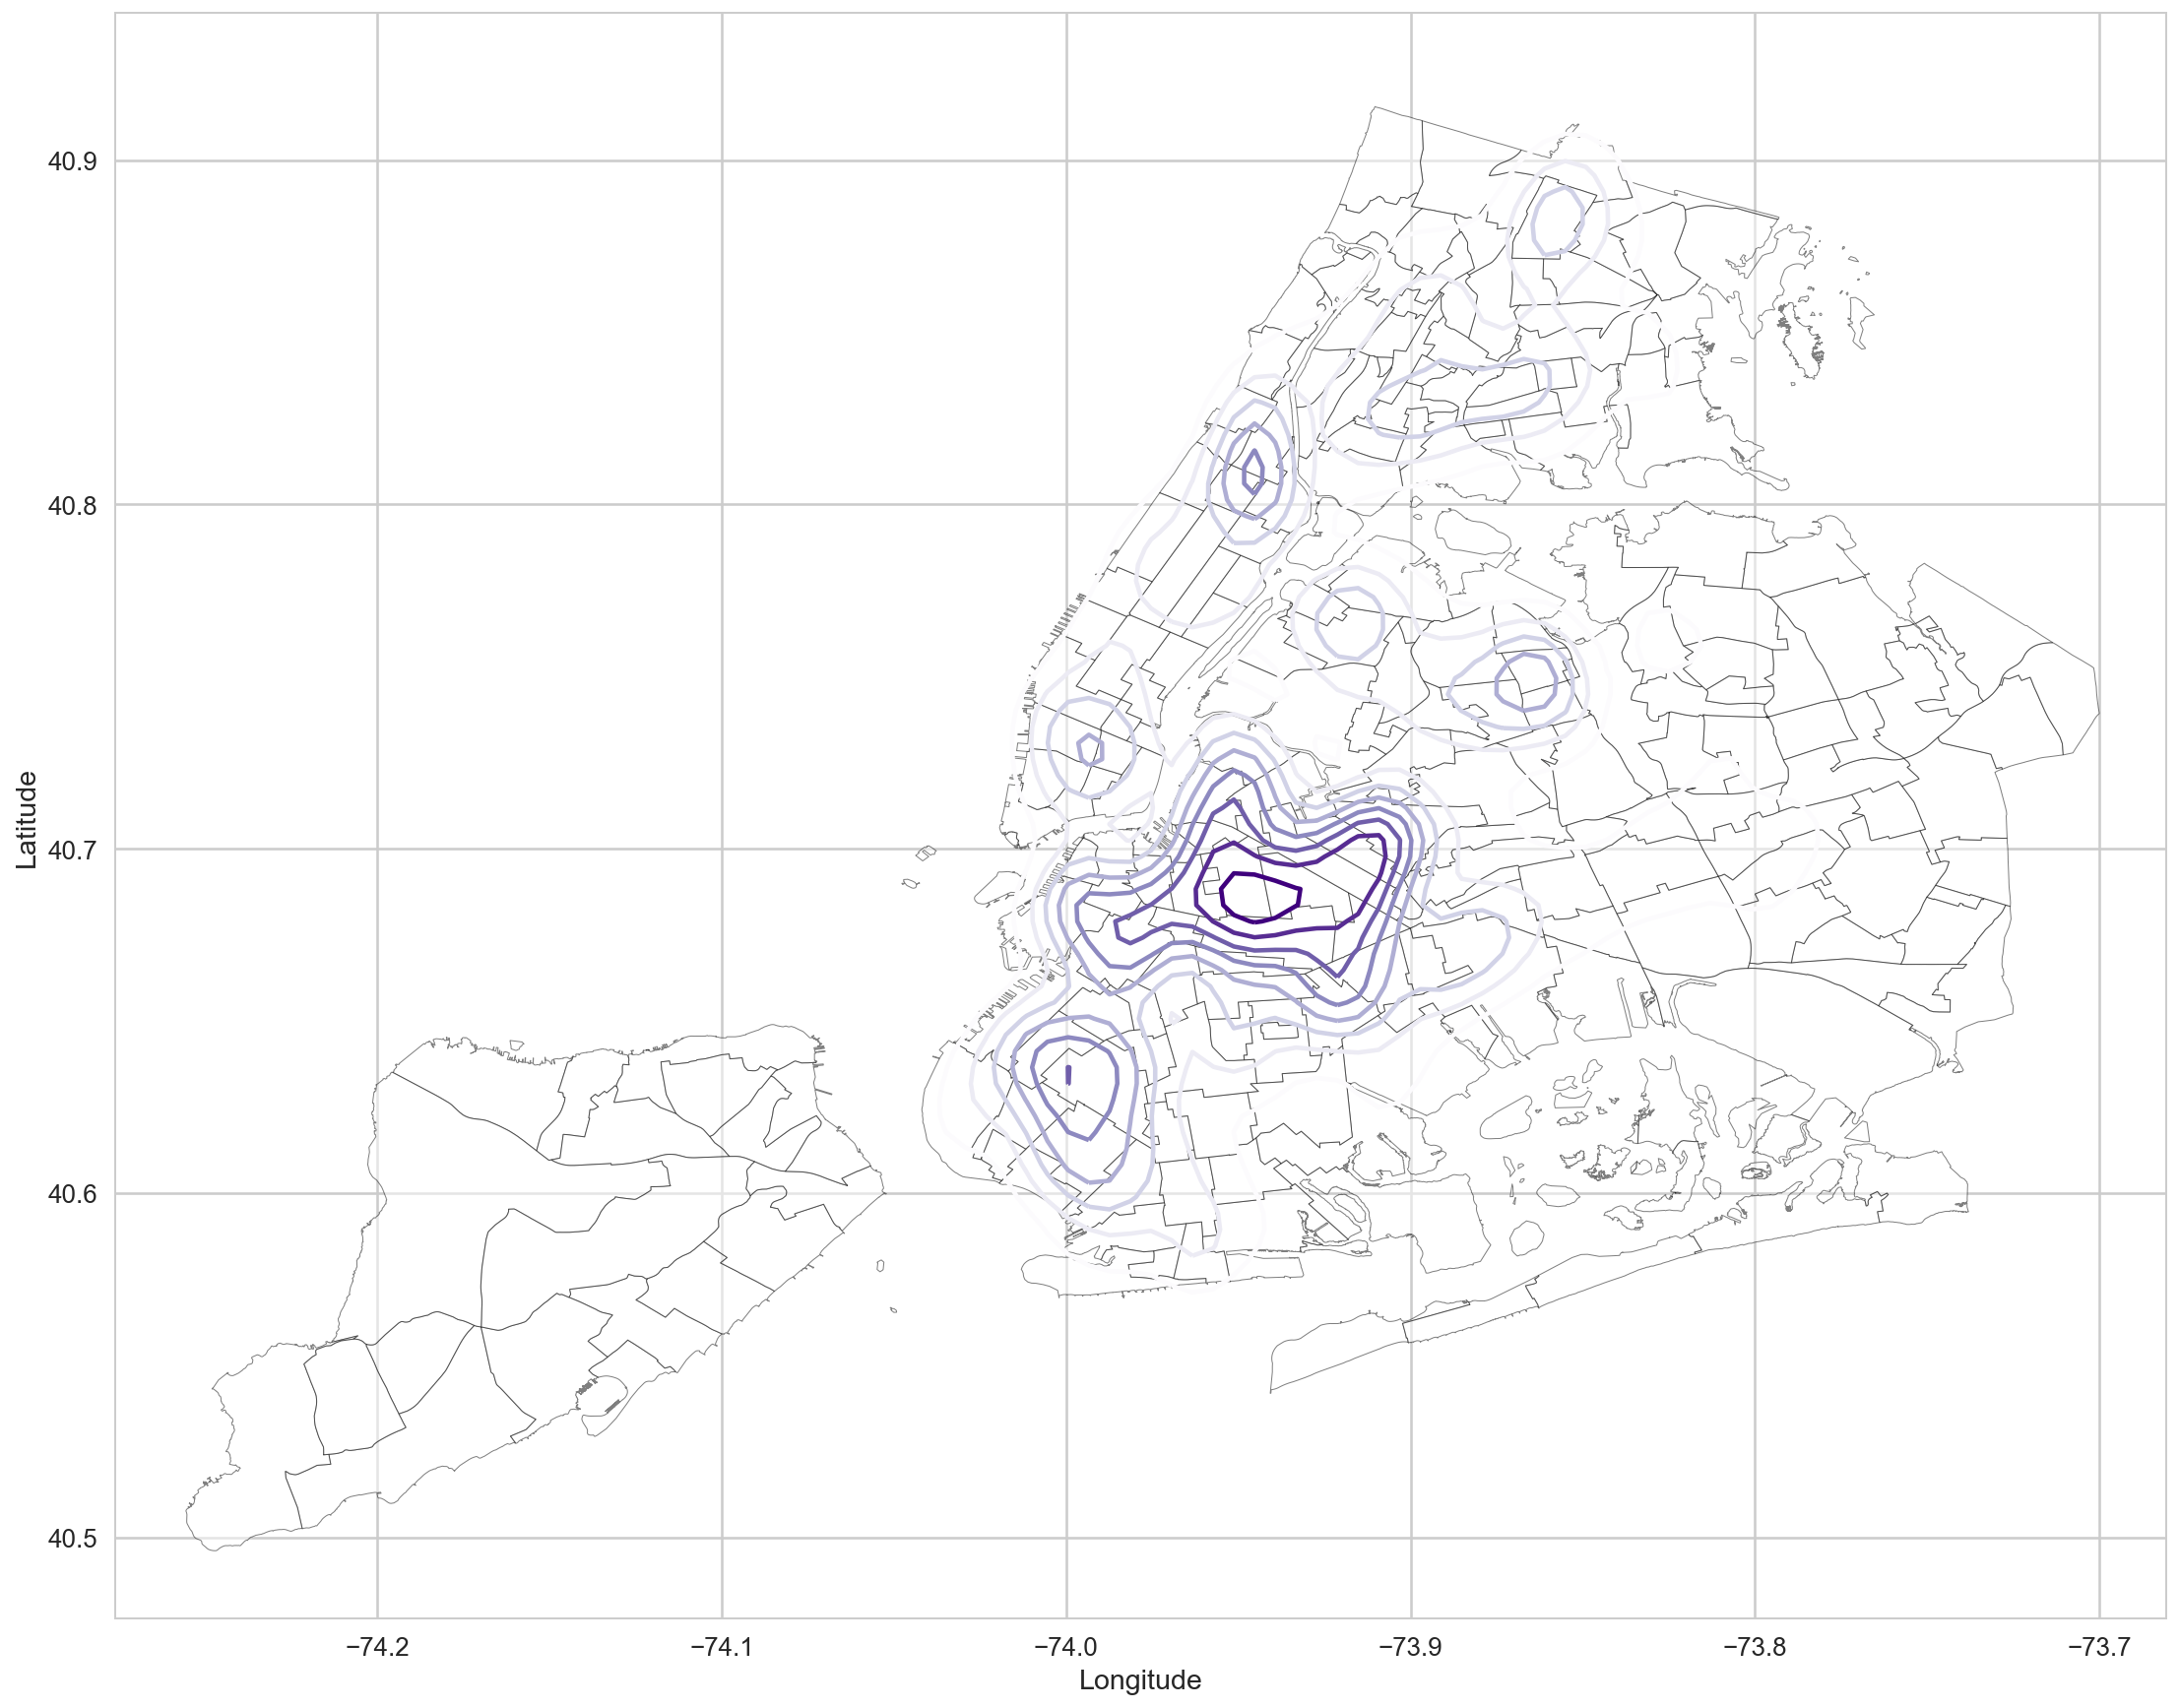

In [75]:
ny_map = df_nyc.plot(linewidth=0.5, color='White', edgecolor = 'Black', figsize = (20,15), alpha=0.5)

sns.kdeplot(
    classI.Longitude, classI.Latitude,
    gridsize=100,
    cmap=plt.cm.Purples,
    shade=False,
    shade_lowest=False,
    n_levels=10,
    ax=ny_map
)

<B> It might be interesting to look at violation rate growth for each borough and see if there
is uneven growth in different boroughs

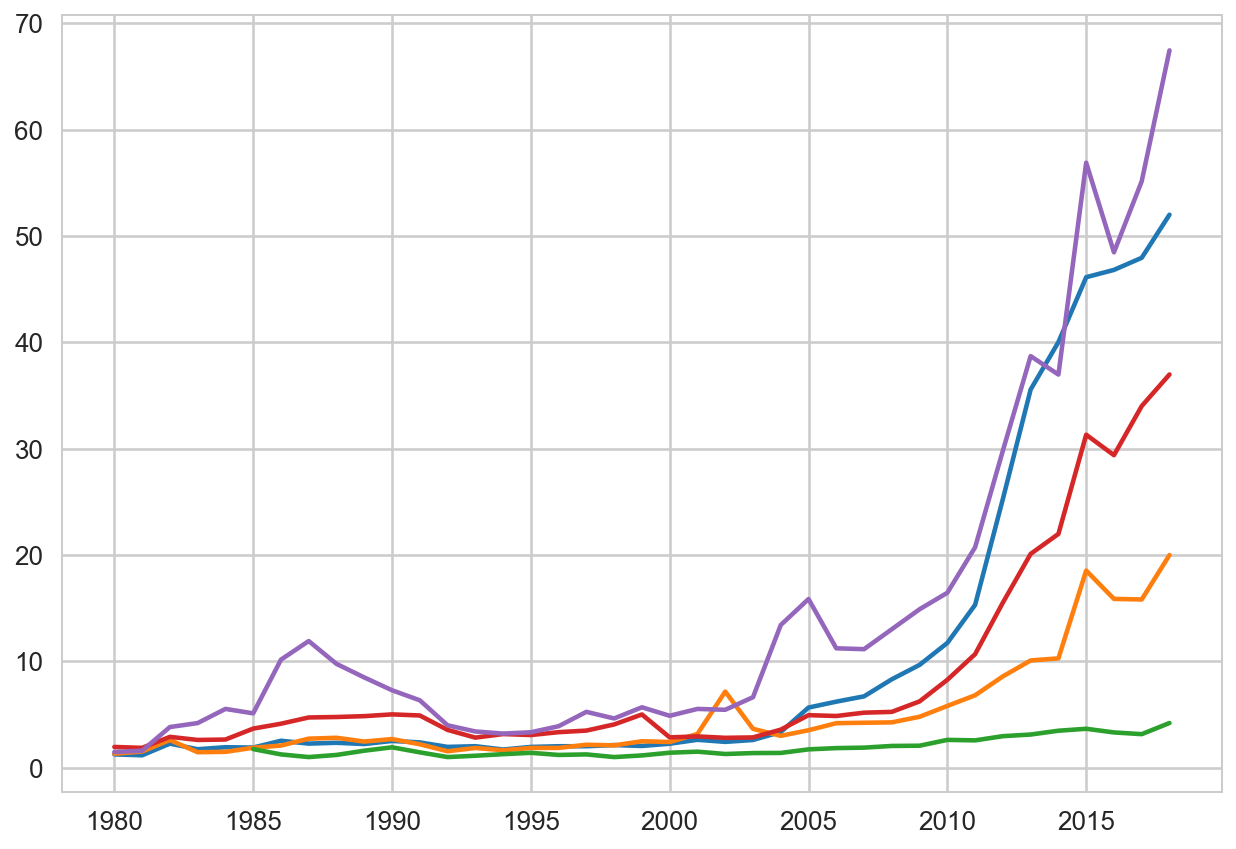

In [76]:
brooklyn = housing_past_1980[housing_past_1980.Borough == 'BROOKLYN']
bronx = housing_past_1980[housing_past_1980.Borough == 'BRONX']
manhattan = housing_past_1980[housing_past_1980.Borough == 'MANHATTAN']
queens = housing_past_1980[housing_past_1980.Borough == 'QUEENS']
staten = housing_past_1980[housing_past_1980.Borough == 'STATEN ISLAND']
bronx.InspectionDate.value_counts().sort_index().resample('AS').mean().plot()
queens.InspectionDate.value_counts().sort_index().resample('AS').mean().plot()
staten.InspectionDate.value_counts().sort_index().resample('AS').mean().plot()
manhattan.InspectionDate.value_counts().sort_index().resample('AS').mean().plot()
brooklyn.InspectionDate.value_counts().sort_index().resample('AS').mean().plot()

<B> We see that Brooklyn has the highest growth, followed by Queens, Manhattan, the Bronx,
and Staten Island respectively. This makes sense because the populations of each borough
from highest to lowest follow this same order.

# Housing Complaints 

<B> From here, we will analyze data for housing complaints and compare the results to that of violations above.

In [46]:
complaints = pd.read_csv("https://data.cityofnewyork.us/api/views/uwyv-629c/rows.csv?accessType=DOWNLOAD")

In [47]:
len(complaints)

1559398

The full data has ake a 10% 1,559,398 sample of the data to make running code easier.

In [48]:
complaints_sample = complaints.sample(frac=0.1)

In [49]:
len(complaints_sample)

155940

<B> Let's take a look at this data.

In [77]:
complaints_sample.columns

Index(['ComplaintID', 'BuildingID', 'BoroughID', 'Borough', 'HouseNumber',
       'StreetName', 'Zip', 'Block', 'Lot', 'Apartment', 'CommunityBoard',
       'ReceivedDate', 'StatusID', 'Status', 'StatusDate'],
      dtype='object')

In [78]:
complaints_sample.head(10)

ComplaintID  BuildingID  BoroughID    Borough HouseNumber  \
461577       7677110       84286          2      BRONX        3018   
1472111      9249288        6261          1  MANHATTAN         461   
1085190      8622714      543575          4     QUEENS      132-01   
452836       7650666      308836          3   BROOKLYN         930   
332365       7403104       87002          2      BRONX        3034   
841053       8300691      375387          3   BROOKLYN         142   
22590        7000856      833594          3   BROOKLYN         185   
1390548      9041420      109449          2      BRONX        1348   
1188808      8780247      294912          3   BROOKLYN        2913   
288895       7374589       49698          2      BRONX        1931   

               StreetName      Zip  Block  Lot Apartment  CommunityBoard  \
461577       HEATH AVENUE  10463.0   3256  176       B10               8   
1472111    AUDUBON AVENUE  10040.0   2159   35      BLDG              12   
1085190        131 AVENUE  11420.0  11771   44       1FL              10   
452836        HART STREET  11237.0   3237   20        2R               4   
332365        HONE AVENUE  10469.0   4578   14         2              12   
841053     ST PAULS PLACE  11226.0   5079   19        3F              14   
22590       GRAHAM AVENUE  11206.0   3043   23         1               1   
1390548   SHERIDAN AVENUE  10456.0   2830   21        5B               4   
1188808     FOSTER AVENUE  11210.0   5216   60        5E              17   
288895   BLACKROCK AVENUE  10472.0   3789   68       2FL               9   

        ReceivedDate  StatusID Status  StatusDate  
461577    10/27/2015         2  CLOSE  10/28/2015  
1472111   10/19/2018         2  CLOSE  10/22/2018  
1085190   09/11/2017         2  CLOSE  09/16/2017  
452836    10/18/2015         2  CLOSE  10/22/2015  
332365    03/20/2015         2  CLOSE  04/07/2015  
841053    12/17/2016         2  CLOSE  12/21/2016  
22590     08/25/2014         2  CLOSE  08/28/2014  
1390548   04/23/2018         2  CLOSE  05/01/2018  
1188808   12/08/2017         2  CLOSE  12/09/2017  
288895    03/03/2015         2  CLOSE  03/06/2015

<B> Here we are looking for the proportion of open and closed complaints. The percentage of open complaints is about 1.51%, which is considerably lower than that of violations.

In [89]:
complaints_status = complaints_sample.groupby('Status').count()
complaints_status['StatusID'].iloc[1]/(complaints_status['StatusID'].iloc[1]+complaints_status['StatusID'].iloc[0])

0.01514685135308452

<B> To see the trend of complaints over time, first convert received and status date into datetime then plot it on a line graph.

In [80]:
complaints_sample['ReceivedDate'] = pd.to_datetime(complaints_sample['ReceivedDate'], format="%m/%d/%Y", errors = 'coerce')
complaints_sample['StatusDate'] = pd.to_datetime(complaints_sample['StatusDate'], format="%m/%d/%Y", errors = 'coerce')

In [81]:
complaints_sample['Time_Until_Approval'] = (abs(complaints_sample['StatusDate'] - complaints_sample['ReceivedDate']))
complaints_sample['Time_Until_Approval'] = (complaints_sample['Time_Until_Approval'] / np.timedelta64(1, 'D')).fillna(0).astype(int)

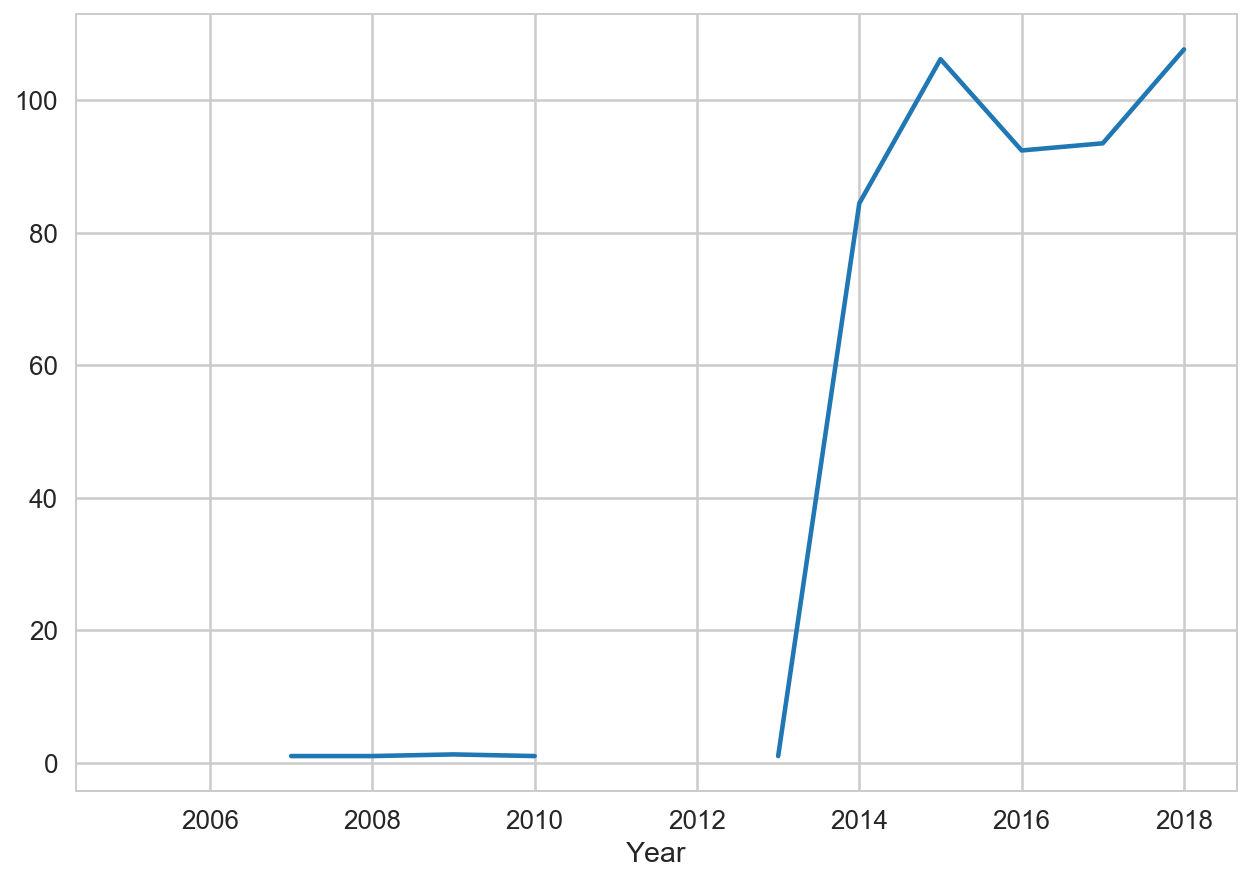

In [82]:
matplotlib.pyplot.xlabel("Year")
complaints_sample.StatusDate.value_counts().sort_index().resample('AS').mean().plot()

<B> There was not enough data in the sample to form a continuous plot, so this is a plot for the original complaints data over time. Keep in mind that the data does not reach back as far as that of violations.

In [83]:
complaints['ReceivedDate'] = pd.to_datetime(complaints['ReceivedDate'], format="%m/%d/%Y", errors = 'coerce')
complaints['StatusDate'] = pd.to_datetime(complaints['StatusDate'], format="%m/%d/%Y", errors = 'coerce')

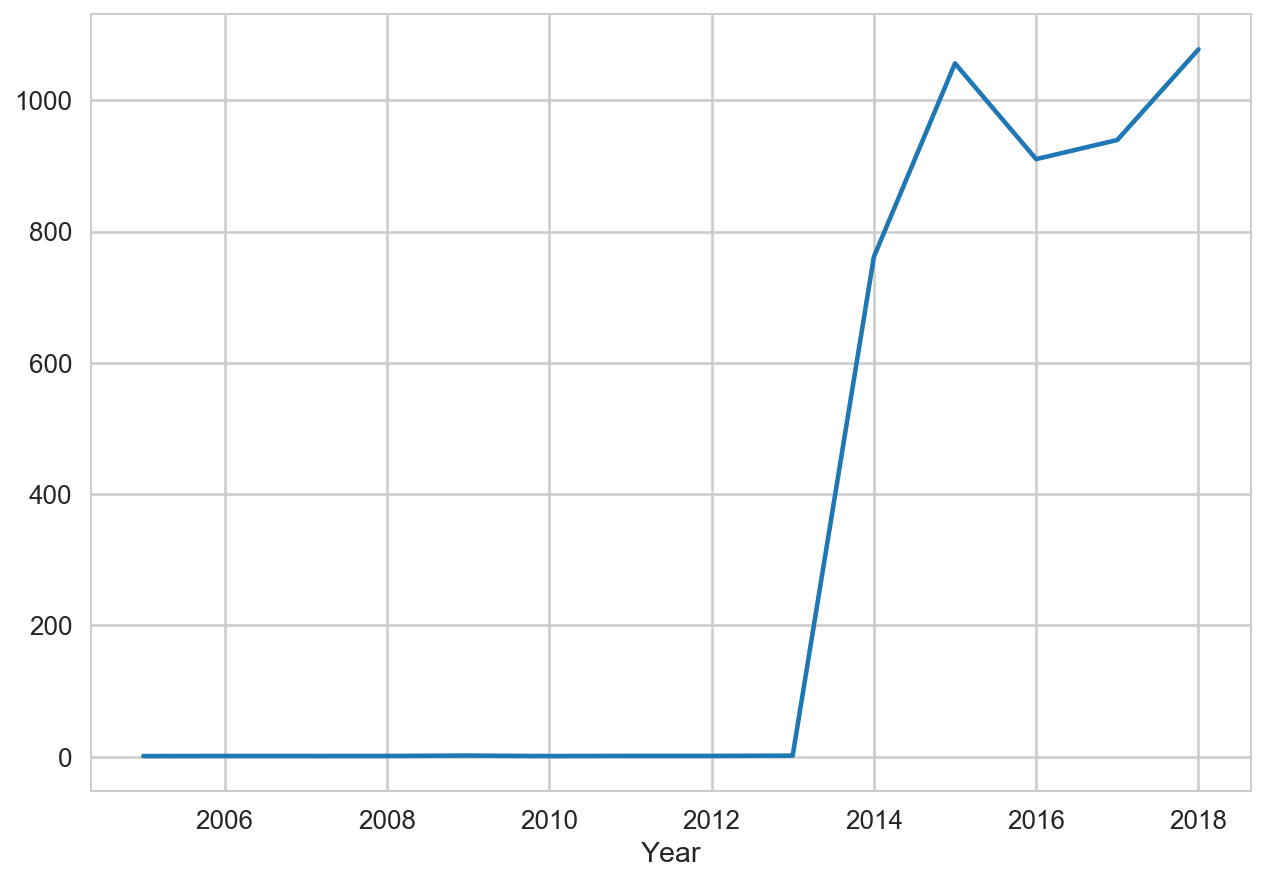

In [84]:
matplotlib.pyplot.xlabel("Year")
complaints.StatusDate.value_counts().sort_index().resample('AS').mean().plot()

<B> There is an obvious spike in housing complaints beginning in the year 2013 and spanning until 2015, similar to the spike in housing violations from 2010 to 2015.

<B> Let's take a look at the number of complaints in the five boroughs. The distribution mimics that of the violations above, where Brooklyn has the most number of complaints.

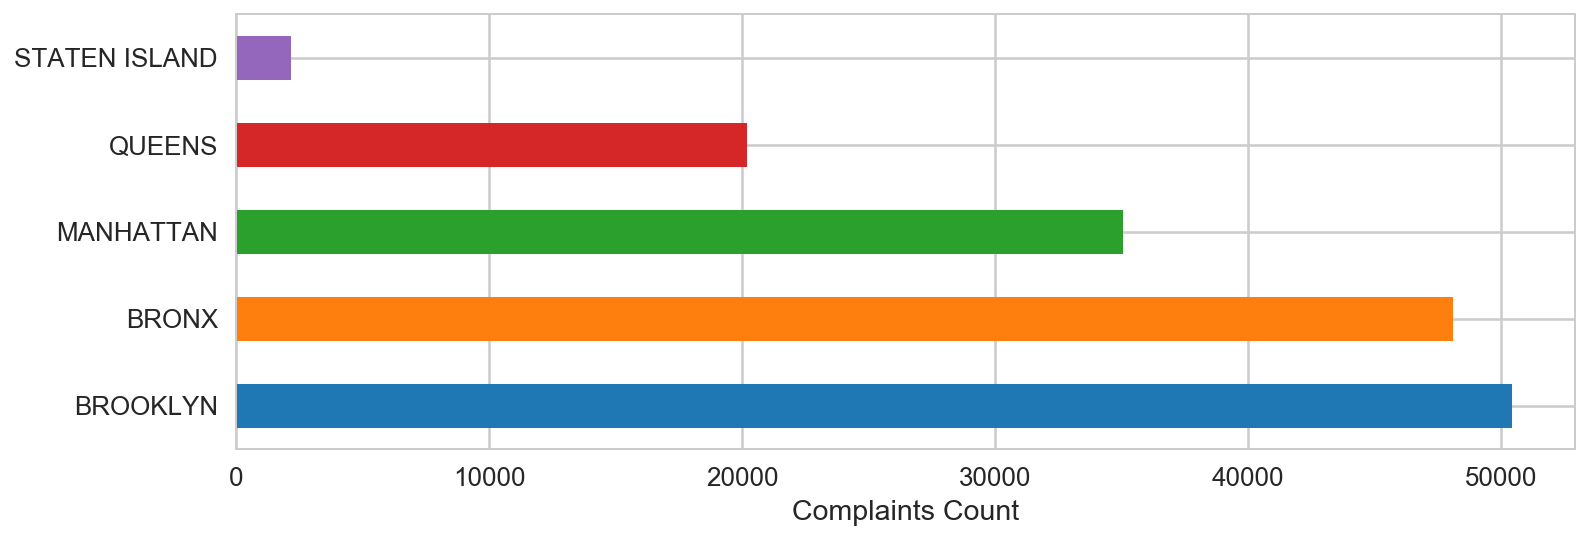

In [85]:
matplotlib.pyplot.xlabel("Complaints Count")
complaints_sample.Borough.value_counts().plot(kind='barh', figsize=(12,4))

<B> Unfortunately, this dataset did not contain any information about any housing complaints escalating into housing violations so we were not able to draw any conclusions on that front. However, we were able to compare the graphs from  the housing complaints data with those for housing violations and note any similarities or differences there.

<B> Although it is not included in this project, regression would be an interesting addition to possibly predict the violation resolution time given location (Borough) and the class of the violation. Both location and class are categorical variables, and we did not find a way to create a regression using categorical predictors.

<B> Here is the link to the github:
https://github.com/amychen/Data_Bootcamp_Final_Project